In [23]:
using PyPlot,Plots,MultiPoly,PyCall,SymPy
default(palette = :viridis)
@pyimport numpy as np;
@pyimport numpy.random as npr;

In [2]:
function ∇Lie(f,g,r,o) # The rudimentary Lie Operator, i.e. the Poisson bracket
    diff(f,r)*diff(g,o)-diff(g,r)*diff(f,o)
end
#
function Lietrx(f,g,r,o,order=ord)  # Taylor series for exponential Lie Transform
    step = ∇Lie(f,g,r,o)
    result = g + step
    for i = 2:order+1
        step = ∇Lie(f,step,r,o)
        result = result + step/factorial(i)
    end    
    return(result)
end

Lietrx (generic function with 2 methods)

In [3]:
m = 1.        #Particle mass, normalized to 1 amu here
k = 6.E9      #Lab: [Teslas/meters^(n-1)] *longitudinal momentum [1 GeV / c] * fundamental charge [A*s]
#k_alt = 1E13 #CoM: [T/meters^(n-1)] * fundamental charge
L = 1E-4      #magnet thin-kick lengths
Ldr = 1E-3    #interspersed drifts

qᵥ, pᵥ = generators(MPoly{Float64}, :q, :p);   #MultiPoly variables for multiparticle calcs
xᵥ = Sym("x")                                  #SymPy varibles for envelope
mᵥ = Sym("m")

Hm = -L /m  * (k/24 * qᵥ^4+ 1/2 * pᵥ^2)           #Octupole hamiltonian (multiparticle)
#Hm_CM = -L * (k_alt/4 * pᵥ * qᵥ^4 + 1/2 * m * pᵥ^2 / 2) #CoM formalism, for reference only
Hdr =  -Ldr/2* pᵥ^2                          #Drift hamiltonian;

### Conversion factor for k:

K = $\frac {k(amu \ m^{2-n} s^{-2}) \cdot m (amu)}  {e(A s^{-1}) \cdot  p(1 GeV c^{-1})}$ 
 
  = Teslas m$^{-n+1}$
  
  i.e.
  
k = 1.93E-7 Tesla $\cdot$ m$^{-3} \cdot$  1.6021766E-19 C $\cdot$ 1GeV c$^{-1}$) ) 

  = 6E9 $(amu \ m^{-2} s^{-2})$
  
  & 
  
  k = 9.73E-7  ""
  
  =3E10 ""  
  

In [4]:
npr.seed(40002)                  
σq = .001        #StDv for position [meters]
σp = .001        #StDv for momentum [meters/second]
N = 1000          #Particle count, set to ~1000 for fast results, 100000 in paper
ord = 3          #Lie transform order of truncation
slc = 200        #number iterated kick--drift sections
mean, cov = [0,0], [(σq^2, 0), (0,σp^2)];

In [5]:
qₒ = Lietrx(Hm,qᵥ,:q,:p)      #output position/momentums for kick/drift sections, rspctv.
pₒ = Lietrx(Hm,pᵥ,:q,:p)
qₒD = Lietrx(Hdr,qᵥ,:q,:p)
pₒD = Lietrx(Hdr,pᵥ,:q,:p);
bGau = npr.multivariate_normal(mean, cov, N)   #Generic bigaussian generator;

In [6]:
#= Primary argument options:
               df = default multivariate expansion (no approximation in momentum)
               zr = null momentum in q expansion
               sg = naive dual-sigmas approximation  (Eqn. 5)
               er = "star" approximation (Eqn. 15)
=#
function LieIter(f,slices=slc)        
    qₓ,pₓ = bGau[:,1], bGau[:,2]
    qₓ₂,pₓ₂ = bGau[:,1], bGau[:,2]    
    
    for j = 1:slc        
        
        if f == "df"       #kicks
            qₓ₃ = [MultiPoly.evaluate(qₒ,qₓ[i],pₓ[i]) for i = 1:length(qₓ)];
        else    
            qₓ₃ = [MultiPoly.evaluate(qₒ,qₓ[i],pₓ₂[i]) for i = 1:length(qₓ)];
        end
        pₓ₃ = [MultiPoly.evaluate(pₒ,qₓ[i],pₓ[i]) for i = 1:length(pₓ)];        
        
        #drifts    
        qₓ₃D = [MultiPoly.evaluate(qₒD,qₓ₃[i],pₓ₃[i]) for i = 1:length(qₓ)];
        pₓ₃D = [MultiPoly.evaluate(pₒD,qₓ₃[i],pₓ₃[i]) for i = 1:length(pₓ)];

        σq = np.std(qₓ₃D)   #Re-setting stdv values
        σp = np.std(pₓ₃D)    
            
        if f != "df"        
            for i =1:length(qₓ)
                if f == "zr"
                    pₓ₂[i] = 0
                elseif f == "sg"
                    pₓ₂[i] = -qₓ₃D[i]*σp/σq        
                elseif f == "er"
                    e_factq = erf(qₓ₃D[i]/(sqrt(2)*σq))/2
                    rhoq = exp(-qₓ₃D[i]^2/(2*σq^2))/sqrt(2*pi*σq^2)
                    pₓ₂[i] = -exp(-2*qₓ₃D[i]*rhoq/e_factq)*(qₓ₃D[i])*σp/σq
                end
             end
        end
         qₓ = copy(qₓ₃D)    
         pₓ = copy(pₓ₃D) 
    end
    return(qₓ,pₓ)
end;

In [7]:
qₓdf, pₓdf = LieIter("df");
qₓzr, pₓzr = LieIter("zr");
qₓsg, pₓsg = LieIter("sg");
qₓer, pₓer = LieIter("er");

In [8]:
spc = Int(length(qₓdf)/500);


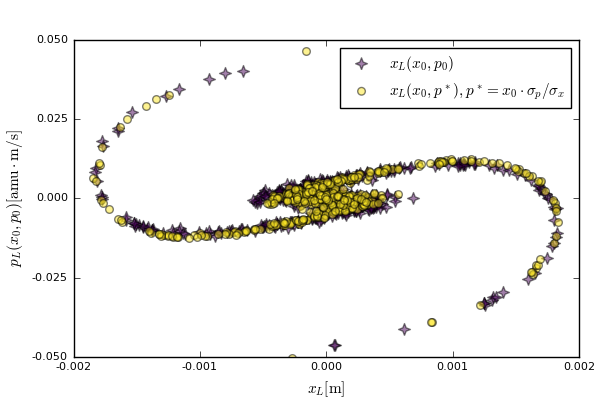

In [9]:
Plots.scatter(qₓdf[1:spc:end],pₓdf[1:spc:end],alpha=.5,
label = L"x_L(x_0,p_0)",m=(:star4,8.5))
Plots.scatter!(qₓsg[1:spc:end],pₓsg[1:spc:end],alpha=.5,m=(:circle,5.5),grid=false,
label = L"x_L(x_0,p^*), p^* = x_0\cdot\sigma_p/\sigma_x")

plot!(ylim=(-.05,.05))
plot!(xlim=(-.002,.002))
xlabel!(L"x_L\rm{[m]}")
ylabel!(L"p_L(x_0,p_0)\rm{[amu \cdot m/s]}")
#
plot!(margin=5px,top_margin=35px,bottom_margin=1px,
legendfont=Plots.font("Helvetica",11))
#Plots.pdf("~/Desktop/sigs")


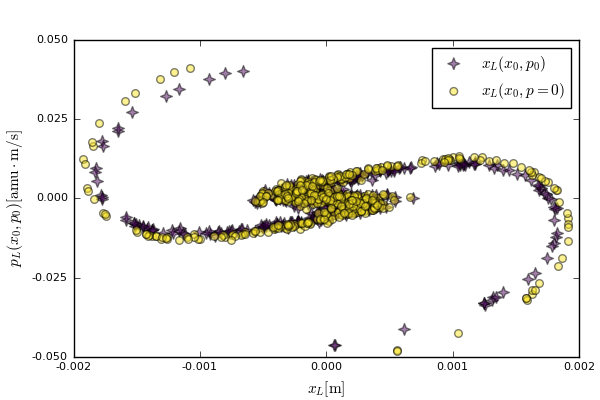

In [10]:
Plots.scatter(qₓdf[1:spc:end],pₓdf[1:spc:end],
alpha=.5,m=(:star4,8.5),grid=false,
label = L"x_L(x_0,p_0)")
Plots.scatter!(qₓzr[1:spc:end],pₓzr[1:spc:end],alpha=.5,
label = L"x_L(x_0,p=0)",m=(:circle,5.5))

plot!(ylim=(-.05,.05))
plot!(xlim=(-.002,.002))

xlabel!(L"x_L\rm{[m]}")
ylabel!(L"p_L(x_0,p_0)\rm{[amu \cdot m/s]}")
#
plot!(margin=5px,top_margin=35px,bottom_margin=1px,
legendfont=Plots.font("Helvetica",11))
#Plots.pdf("~/Desktop/zeros")


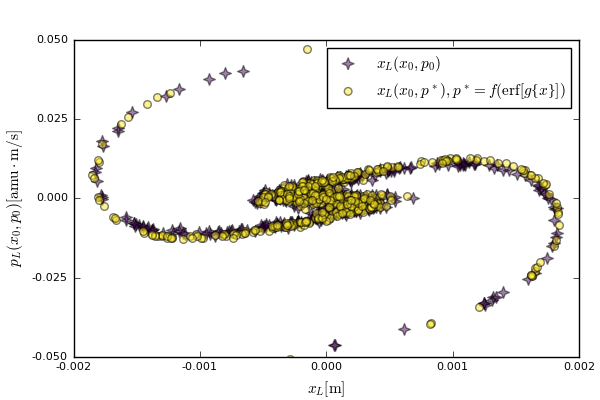

In [11]:
Plots.scatter(qₓdf[1:spc:end],pₓdf[1:spc:end],
alpha=.5,m=(:star4,8.5),grid=false,
label = L"x_L(x_0,p_0)")
Plots.scatter!(qₓer[1:spc:end],pₓer[1:spc:end],alpha=.5
,label = L"x_L(x_0,p^*), p^* = f ( \operatorname{erf} [g \lbrace x \rbrace] )",m=(:circle,5.5))

plot!(ylim=(-.05,.05))
plot!(xlim=(-.002,.002))

xlabel!(L"x_L\rm{[m]}")
ylabel!(L"p_L(x_0,p_0)\rm{[amu \cdot m/s]}")
#
plot!(margin=5px,top_margin=35px,bottom_margin=1px,
legendfont=Plots.font("Helvetica",11))
#Plots.pdf("~/Desktop/erf")

# Envelope Tests
## (Sympy-based)

In [12]:
σₓ = 0.001  #stdv. for position and momentum
σm = 0.001  

ρ = 1/(sqrt(2*pi*σₓ^2))*exp(-xᵥ^2/(2*σₓ^2)) #gaussian distributions (monovariate)
ρm = 1/(sqrt(2*pi*σm^2))*exp(-mᵥ^2/(2*σm^2)) #gaussian distribution (monovariate)

χ = erf(xᵥ/(sqrt(2)*σₓ))/2                        
χm = erf(mᵥ/(sqrt(2)*σm))/2      

m_str = exp(-2*ρ*xᵥ/χ)*xᵥ*σm/σₓ; #Eqn. 17
x_str = exp(-2*ρm*mᵥ/χm)*mᵥ*σₓ/σm #Eqn. 18;

In [13]:
k = 3E10    #Default: 3E10 for position, 6E9 for momentum
L = 1E-2     #Default: 1E-2
Hm_s = -L/m * (k/24 * xᵥ^4+ 1/2 * mᵥ^2)         # Same as above, for envelope
N = 1000   #Default 100000
ord = 4
xₒ = Lietrx(Hm_s,xᵥ,xᵥ,mᵥ)  #default outputs for envelope
mₒ = Lietrx(Hm_s,mᵥ,xᵥ,mᵥ);

In [14]:
xₒapr = xₒ(mᵥ=>m_str)  #outputs with approximations
mₒapr = mₒ(mᵥ=>m_str)

bGau = npr.multivariate_normal(mean, cov, N)   #Generic bigaussian generator;
xₓ,mₓ = bGau[:,1], bGau[:,2]
xₒλ = lambdify(xₒ)(xₓ,mₓ)     #lambdifying both outputs
xₒλapr = lambdify(xₒapr)(xₓ);
mₒλ = lambdify(mₒ)(xₓ,mₓ)     
mₒλapr = lambdify(mₒapr)(mₓ);

In [15]:
dxₒdx = diff(xₒ,xᵥ)
dmₒdm = diff(mₒ,mᵥ)
dxₒdm = diff(xₒ,mᵥ)  
dmₒdx = diff(mₒ,xᵥ);

In [16]:
Jcb = dxₒdx*dmₒdm #Nonzero element of 2D Jacobian
Jcb = (Jcb(mᵥ=>m_str))
Jcb = removeO(series(Jcb,xᵥ))   
Jcb_chk = dxₒdx(mᵥ=>m_str)
Jcb_chk = removeO(series(Jcb_chk,xᵥ))

ρₒ = ρ/abs(Jcb)   #Eqn. 23
ρₒchk = ρ/abs(Jcb_chk) #"Uncoupled" version;

In [17]:
Jcbm = dxₒdx*dmₒdm #Same as above, now for momentum
Jcbm = (Jcbm(xᵥ=>x_str))
#Jcbm = removeO(series(Jcbm,xᵥ, n=ord))    
Jcb_chkm = dxₒdx(xᵥ=>x_str)
#Jcb_chkm = removeO(series(Jcb_chkm,xᵥ, n=ord))

ρₒm = (ρm/abs(Jcbm))
ρₒchkm = ρm/abs(Jcb_chkm);

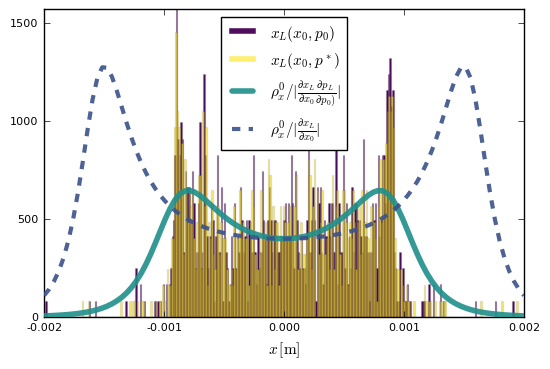

In [18]:
xr = .002 #x-range
bns = 500  #bins, default 1000

histogram(xₒλ,alpha=0.95,bins=bns,line=0.1,normed=true,label=L"x_L(x_0,p_0)")
histogram!(xₒλapr,alpha=.65,bins=bns,line=0.1,normed=true,label=L"x_L(x_0,p^*)")

plot!(ρₒ,-xr,xr,line=(.91,4), 
label=L"\rho^0_x /|\frac{\partial x_L}{\partial x_0}\frac{\partial p_L}{\partial p_0)}|")

plot!(ρₒchk,-xr,xr,line=(.91,3),linestyle=(:dash),
label=L"\rho^0_x / |\frac{\partial x_L}{\partial x_0}|")

plot!(margin=35px,top_margin=15px,xlabel=(L"x\/\rm{[m]}"),legendfont=Plots.font("Helvetica",11))
plot!(xlim=(-xr,xr),grid=false)
Plots.pdf("/Users/benfolsom/Desktop/envpos")

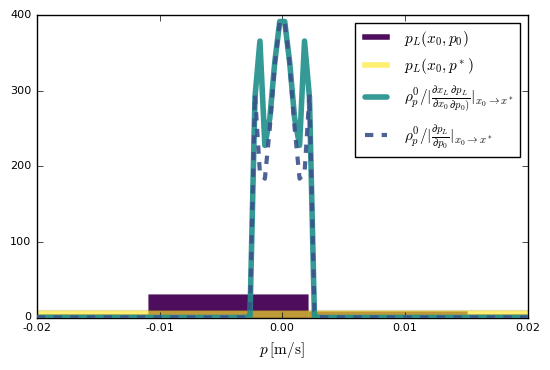

In [19]:
xr = .02 #x-range
bns = 500 #bins, default 1500

histogram(mₒλ,alpha=0.95,bins=bns,line=0.1,normed=true,label=L"p_L(x_0,p_0)",)
histogram!(mₒλapr,alpha=.65,bins=bns,line=0.1,normed=true,label=L"p_L(x_0,p^*)")

Plots.plot!(ρₒm,-xr,xr,line=(.91,4),
label=L"\rho^0_p /|\frac{\partial x_L}{\partial x_0}\frac{\partial p_L}{\partial p_0)}|_{x_0\rightarrow x^*}")
plot!(ρₒchkm,-xr,xr,line=(.91,3), linestyle=(:dash), 
label=L"\rho^0_p / |\frac{\partial p_L}{\partial p_0}|_{x_0\rightarrow x^*}")

plot!(margin=35px,top_margin=15px,xlabel=(L"p\/\rm{[m/s]}"),legendfont=Plots.font("Helvetica",11))
plot!(xlim=(-xr,xr),grid=false,ylim=(0,400))
Plots.pdf("/Users/benfolsom/Desktop/envmom")

In [20]:
#These were produced manually from the 
#multiparticle block above using the @time magic

N = [300,500,800,1500,2500,3500,5000,8000,12000,16000]
lieMal = [.738,1.232,2.2,4.48,7.73,10.98,15.86,25.6,38.64,51.66]
pstMal = [.618,1.03,1.88,3.88,6.73,9.58,13.86,22.4,33.84,45.26]

N0 = [4,6,8,10,12,14,16,18,20]
lieMal0 = [2.8,3.25,3.85,4.5,5.3,6.15,7.15,8.2,9.4]
pstMal0 = [2.55,2.85,3.2,3.6,4.05,4.55,5.1,5.7,6.55]


Nsc = [300,500,800,1500,2500,3500,8000,16000]
lieMalsc = [.619,.799,1.04,1.47,1.63,1.83,3.31,5.22]
pstMalsc = [.362,.479,.65,.97,1.18,1.39,2.71,4.58];


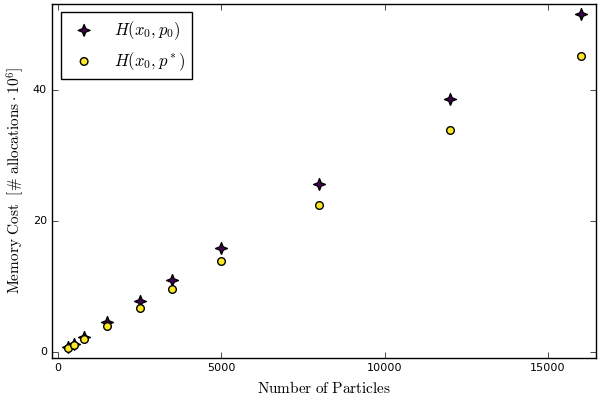

In [21]:
f = "Sans";
default(tickfont = font(f,8),
guidefont = font(f,11),
legendfont = font(f,12))

Plots.scatter(N,lieMal,label=L"H(x_0,p_0)",m=(:star4,8.5))
Plots.scatter!(N,pstMal, grid=false,label=L"H(x_0,p^*)",leg=:topleft,m=(:circle,5.5))
plot!(ylabel=L"\mathrm{Memory \ Cost}  \ \ [\# \ \mathrm{allocations} \cdot 10^6]")
plot!(xlabel=L"\mathrm{Number \ of \ Particles}")
#Plots.pdf("~/benfolsom/Desktop/benchpart")


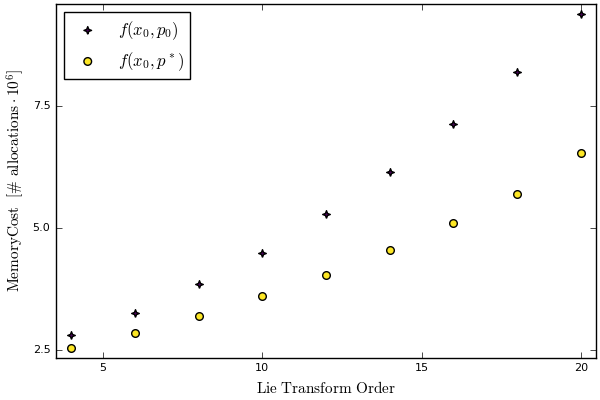

In [22]:
f = "Sans";
default(tickfont = font(f,8),
guidefont = font(f,11),
legendfont = font(f,12))

Plots.scatter(N0,lieMal0,label=L"f(x_0,p_0)",m=(:star4,5.5))
Plots.scatter!(N0,pstMal0, grid=false,label=L"f(x_0,p^*)",leg=:topleft,m=(:circle,5.5))
plot!(ylabel=L"\mathrm{Memory Cost}  \ \ [\# \ \mathrm{allocations} \cdot 10^6]")
plot!(xlabel=L"\mathrm{Lie \ Transform \ Order}")
#Plots.pdf("~/Desktop/benchord")